In [ ]:
%%capture
!pip install feature-engine

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

pd.pandas.set_option('display.max_columns', None)

In [ ]:
# below two are for correltation
from sklearn.model_selection import train_test_split, cross_validate

from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile


In [ ]:
# load dataset
fields = ['SPECIES','STORAGE_TYPE','GEAR_NME','MGMT_AREA','LICENCE_AREA','DATE','Vessel ID Number','GEAR_CDE','SUB_AREA'
,'SA_ORIGIN','Nominal_Value','KG_PIECE','Nominal_PRICE_PIECE']
data=pd.read_csv('q2.csv', error_bad_lines=False,usecols=fields)
# data=pd.read_csv('q2.csv', error_bad_lines=False)

print(data.shape)
data.head()

(566739, 13)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SPECIES,STORAGE_TYPE,GEAR_NME,MGMT_AREA,LICENCE_AREA,DATE,Vessel ID Number,GEAR_CDE,SUB_AREA,SA_ORIGIN,KG_PIECE,Nominal_PRICE_PIECE,Nominal_Value
0,CHUM SALMON,UNKNOWN,SEINE,13,SALMON AREA B,10/17/2016,4856,20,28,LOG_BOOK,4.391591,8.540229,227298.1995
1,CHUM SALMON,UNKNOWN,SEINE,14,SALMON AREA B,11/6/2011,3980,20,4,LOG_BOOK,4.595482,8.611520,215287.9969
2,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/12/2018,3952,20,3,LOG_BOOK,2.685285,16.368153,212785.9900
3,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/14/2018,3820,20,4,LOG_BOOK,2.781680,16.406279,205078.4896
4,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/12/2018,5448,20,3,LOG_BOOK,2.781614,16.955322,178030.8788


In [ ]:
#LOOK FOR CONSTANT FIELDS
for col in data:
    print(col, data[col].unique())

SPECIES ['CHUM SALMON' 'SOCKEYE SALMON' 'PINK SALMON' 'CHINOOK SALMON'
 'COHO SALMON']
STORAGE_TYPE ['UNKNOWN' 'FROZEN' 'ICED']
GEAR_NME ['SEINE' 'GILL NET' 'TROLL']
MGMT_AREA [ 13  14  29   2  12  21   7  23   3  18  20   8  28  17   1  16  25   4
 142   6 101 121   5 126 124  11  10 127 104 123 102  26 103 105  27 125
 106 111 107  24  19 108 130]
LICENCE_AREA ['SALMON AREA B' 'SALMON AREA A' 'SALMON AREA C' 'SALMON AREA E'
 'SALMON AREA D' 'SALMON AREA F' 'SALMON AREA H' 'SALMON AREA G']
DATE ['10/17/2016' '11/6/2011' '9/12/2018' ... '2/20/2018' '12/31/2015'
 '2/8/2015']
Vessel ID Number ['4856' '3980' '3952' ... 4509 4172 4163]
GEAR_CDE [20 10 30 31]
SUB_AREA [ 28   4   3   6  10  27  31   2  30  32   8  29  40   7   1   0  11  14
   9   5  13  17  16  43  33  12  35  46  45  21  88  15  26  19  67  48
  63  47  68  78  49  97  79  76  38  18  24  20  69  86  75  66 100  92
  98  23  36  25  89]
SA_ORIGIN ['LOG_BOOK' 'OPNG_DESC' 'TROLL_ZONE']
KG_PIECE [4.39159149 4.59548231 2.68528

In [ ]:
# Disaggregate date 
data[["month", "day", "year"]] = data["DATE"].str.split("/", expand = True)
data.drop(['DATE', 'day'], axis=1 , inplace=True)
data.head(2)

,SPECIES,STORAGE_TYPE,GEAR_NME,MGMT_AREA,LICENCE_AREA,Vessel ID Number,GEAR_CDE,SUB_AREA,SA_ORIGIN,KG_PIECE,Nominal_PRICE_PIECE,Nominal_Value,month,year
0,CHUM SALMON,UNKNOWN,SEINE,13,SALMON AREA B,4856,20,28,LOG_BOOK,4.391591,8.540229,227298.1995,10,2016
1,CHUM SALMON,UNKNOWN,SEINE,14,SALMON AREA B,3980,20,4,LOG_BOOK,4.595482,8.611520,215287.9969,11,2011


In [ ]:
# Inspected the type of variables in pandas, and changed as appropriate
for col in ['MGMT_AREA','GEAR_CDE','SUB_AREA']:
    data[col] = data[col].astype(object)
# for col in ['month','year']:
#     data[col] = data[col].astype('int64')
data.dtypes

SPECIES                 object
STORAGE_TYPE            object
GEAR_NME                object
MGMT_AREA               object
LICENCE_AREA            object
Vessel ID Number        object
GEAR_CDE                object
SUB_AREA                object
SA_ORIGIN               object
KG_PIECE               float64
Nominal_PRICE_PIECE    float64
Nominal_Value          float64
month                   object
year                    object
dtype: object

In [ ]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 11 categorical variables


In [ ]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain temporal information
temporal_vars = [var for var in categorical if 'month' in var or 'year' in var]




numerical, temporal_vars

(['KG_PIECE', 'Nominal_PRICE_PIECE', 'Nominal_Value'], ['month', 'year'])

Text(0, 0.5, 'Nominal value')

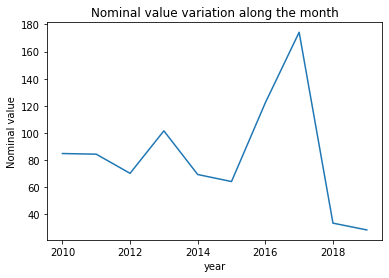

In [ ]:
# plot nominal value per month or year

data.groupby('year')['Nominal_Value'].median().plot()
plt.title('Nominal value variation along the month')
plt.ylabel('Nominal value')

In [ ]:
# tabulate nominal value per species or other catefory
data.groupby('MGMT_AREA')['Nominal_Value'].median().sort_values(ascending=False).reset_index()

,MGMT_AREA,Nominal_Value
0,28,9.548010e+03
1,16,1.084378e+03
2,20,9.372143e+02
3,21,7.128800e+02
4,107,6.210167e+02
5,108,5.700377e+02
6,10,4.248903e+02
7,18,3.850721e+02
8,102,3.529980e+02
9,126,3.244044e+02


In [ ]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 30:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))


There are 0 discrete variables


In [ ]:
# find continuous variables
# skip the target and correlated vars
continuous = [var for var in numerical if var not in discrete  
              and var not in ['Nominal_Value']]

print('There are {}  continuous variables'.format(len(continuous)))

There are 2  continuous variables


In [ ]:
# let's output variables with NA and the percentage of NA

for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())


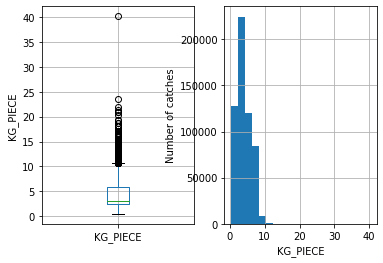

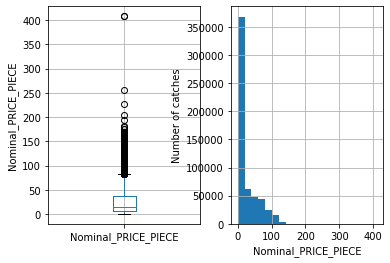

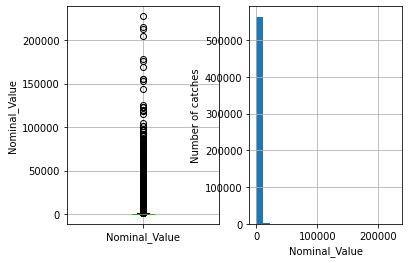

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of catches')
    fig.set_xlabel(var)

    plt.show()

Text(0, 0.5, 'Number of different categories')

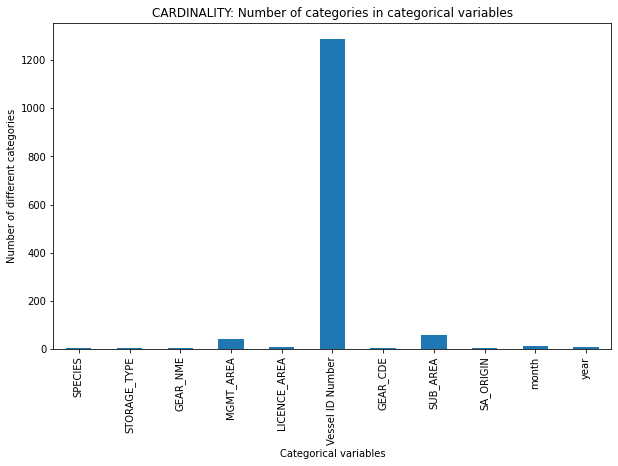

In [ ]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [ ]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop('Nominal_Value', axis=1),
                                                    data['Nominal_Value'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape



((510065, 13), (56674, 13))

In [ ]:
fisheries_pipe = Pipeline([

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=6, variables=categorical)),
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical)),

    # discretisation + encoding - section 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=continuous)),
   
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=continuous)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),
    
    # regression
    # ('lasso', Lasso(random_state=0))
    ('classifier', RandomForestRegressor(random_state=10))

    
])


In [ ]:
# let's fit the pipeline
fisheries_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = fisheries_pipe.predict(X_train)
X_test_preds = fisheries_pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable SPECIES is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable STORAGE_TYPE is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_NME is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_CDE is less tha

In [ ]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 2318047.0417700754
train rmse: 1522.5133962530758
train r2: 0.6014876615558482

test mse: 1901749.0999070406
test rmse: 1379.0391944781848
test r2: 0.562076221746925


Text(0, 0.5, 'Predicted Price')

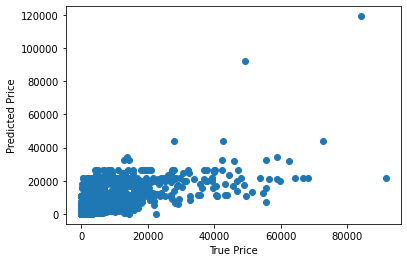

In [ ]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

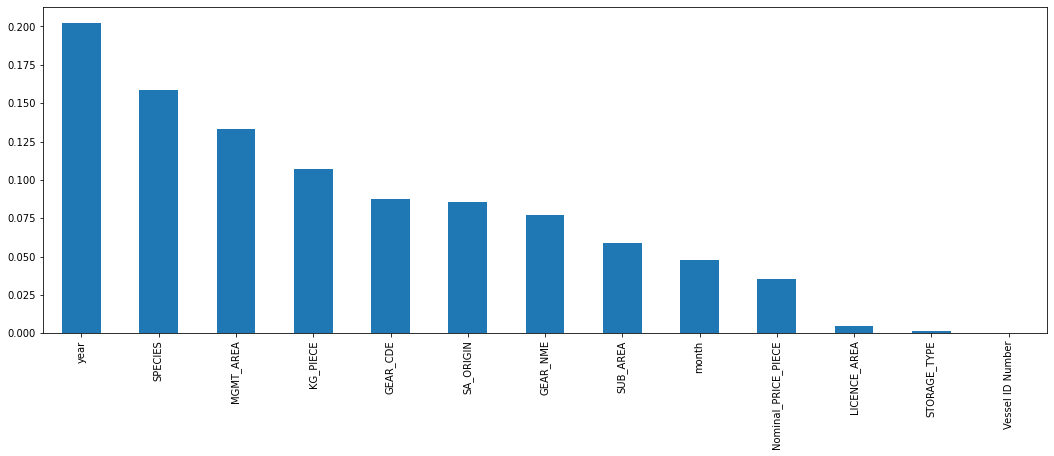

In [ ]:
# let's explore the importance of the features

importance = pd.Series(np.abs(fisheries_pipe.named_steps['classifier'].feature_importances_))
importance.index = list(X_train.columns) 
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))


In [ ]:
print(X_test_preds)

array([  80.52510546, 4146.00819134,  376.74331345, ...,   25.65437041,
         72.13179902,  916.87298565])